If you are running this locally, please make sure you have Cuda Enabled, and  Pytorch 1.x installed with GPu support.

You can also try this notebook on Google colab : 
 [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IhabBendidi/img_classification_benchmark/blob/main/CNN_benchmark.ipynb)

Whether locally or on Colab, if it's the first time running this notebook, uncomment (delete the """) and run the following command to install all necessary dependencies (Pytorch must be installed manually).


In [ ]:
"""
!wget https://github.com/IhabBendidi/img_classification_benchmark/blob/main/requirements.txt
!pip3 install -r requirements.txt
"""

## Image Classification Benchmark using deep learning & convolutional networks

**Author :** *Ihab BENDIDI*

Image classification is considered a resolved task in academia. A lot of model architectures have appeared on the subject, achieving very high performance, starting from Alexnet, to some very accurate recent models. These models have also proven the possibility of using their weights on new tasks, which got called on Transfer Learning. This work is a comparative benchmark between the recent image classification models, using models trained from scratch built on known architectures, as well as finetuning and applying transfer learning on other pretrained models, while freezing different layers for comparative purposes.

### Outline

Apart from the first big section that should always be run at the start of the notebook, all other big and small sections can be run independantly from each other, without interference.

**I - Data Preparation and Helper Functions**
1. *Data Preparation*
2. *Train/Test Helper Functions*

**II - Pretrained Model : Resnet**
1. *Finetune all layers*
2. *Finetune the two last layers*
3. *Finetune only the last layer*

**III - Existing Architecture : SqueezeNet**
1. *Pretrained Model : Finetuning classification layer*
2. *Training the model from scratch*

**IV - CNN model from scratch**

We would begin first of all by importing all the necessary libraries for what follows.

In [1]:
import time
import copy
from collections import defaultdict

from pylab import rcParams

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import sampler,DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2 as cv

from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 12

We also set the device for training the models to GPU if it exists, and it would default to CPU if GPU and CUDA are not enabled.

If you're on Google Colab, make sure you are running on GPU.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We'll also download the image of a cat that we'll be using for a few interesting visualizations later on. You will find more details about it later.

In [ ]:
!wget --output-document=cat.jpg https://img.webmd.com/dtmcms/live/webmd/consumer_assets/site_images/article_thumbnails/other/cat_relaxing_on_patio_other/1800x1200_cat_relaxing_on_patio_other.jpg?resize=750px:*

### I - Data preparation and helper functions

#### 1 - Data preparation

Our first step would be data preparation. We'll be using Pytorch throughout this notebook. The same results can still be reached through the usage of Tensorflow or Keras.

We begin by preparing a transformation for our data, by normalizing the images.

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

The dataset used is CIFAR-10, which is a dataset that consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. We import the dataset from Pytorch datasets.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

More details about the dataset can be found [here](https://www.cs.toronto.edu/~kriz/cifar.html).

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified


In [6]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified


We would try to separate the trainset into another training set and a validation set. We observe that the number of observations in the trainset is 50000.

In [7]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

At the same time, the number of observations in the test set is 10000 observation, which we take note of for later usage.

In [8]:
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [9]:
size_test = 10000

To separate our training and validation data, as it is not separated by default in the Cifar Dataset, we would define a class that would sequentially sample a chunk of the training data, to use as a validation set.

In [10]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

We then separate the data into a 49.000 / 1000 split for training and validation, and we define pytorch dataloaders with a batch size of 16, as this batch size has proven to give the best results in the experiments that follow.

In [11]:
NUM_TRAIN = 49000
NUM_VAL = 1000

loader_train = DataLoader(trainset, batch_size=16,num_workers=4,sampler=ChunkSampler(NUM_TRAIN, 0))

loader_val = DataLoader(trainset, batch_size=16,num_workers=4,sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

In [12]:
dataloaders = {'train':loader_train,'val':loader_val}
dataset_sizes = {'train':NUM_TRAIN,'val':NUM_VAL}

In [13]:
loader_test = DataLoader(testset, batch_size=16, shuffle=True,num_workers=4)

We define a function for rendering images, and we define in a list the labels of our classification classes.

In [14]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()

In [15]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

We can observe below a number of images in our training dataset, with their labels below.

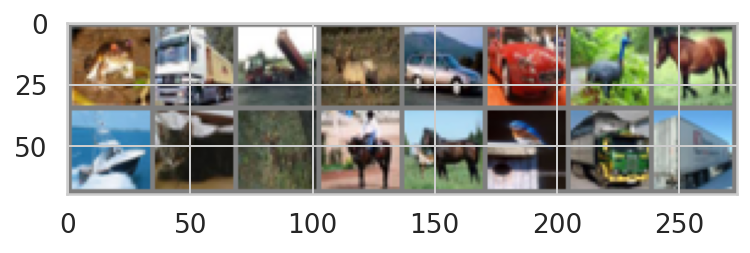

 frog truck truck  deer   car   car  bird horse  ship   cat  deer horse horse  bird truck truck


In [16]:
# get some random training images
dataiter = iter(loader_train)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

We also make sure to visualize the image we downloaded of the cat, to check its quality.

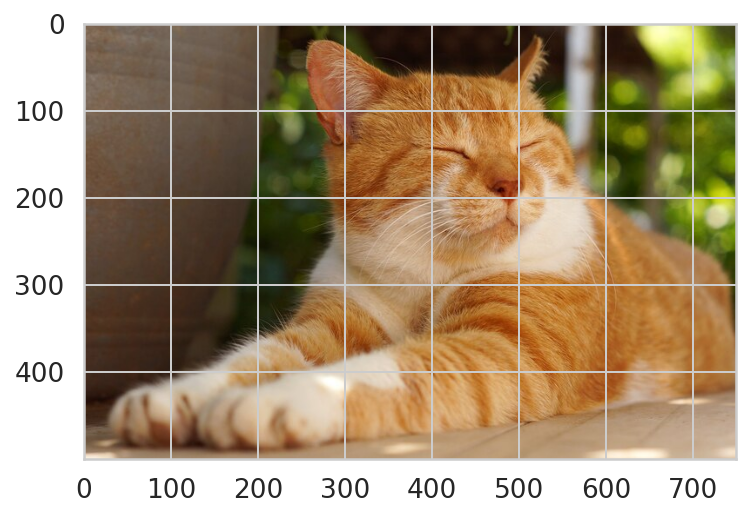

torch.Size([3, 500, 750])
torch.Size([1, 3, 500, 750])


In [17]:
# read and visualize an image
img = cv.imread("./cat.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

img = np.array(img)
# apply the transforms
img = transform(img)
print(img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())

#### 2 - Train/Test helper functions

We define a few functions that would help us greatly in the training later on, to keep the code cleaner.

The first function helps with training the model. It computes the accuracy and loss for each epoch, for training and validation data, and saves the models with the best validation accuracy, for usage later on, as well as the training history, for visualization.

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = defaultdict(list)
    model = model.to(device)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'train' :
                train_acc = epoch_acc
                train_loss = epoch_loss 
            else :
                val_acc = epoch_acc 
                val_loss = epoch_loss 

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'best_model_state.bin')

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    model = model.to(device)
    return model,history

The next function is the evaluation function, with which we'll evaluate our models on the test data.

In [19]:
def eval_model(model, data_loader, loss_fn):
    model = model.eval()

    losses = []
    correct_predictions = 0
    model = model.to(device)
    loss_fn = loss_fn.to(device)

    with torch.no_grad():
        for d in data_loader:

            # Preparing inputs
            images, targets = d
            targets = targets.to(device)
            images = images.to(device)
            

            # Running inference using the model

            outputs = model(images)
            
            # Running softmax on the outputs
            _, preds = torch.max(outputs.data, dim=1)

            # Computing loss function
            loss = loss_fn(outputs, targets)

            # Counting the correct occurences
            correct_predictions += torch.sum(preds == targets)

            # Computing the precision (true positives/true positives + false positives) 
            # for each class and label, and find their average weighted by support 

            losses.append(loss.item())

    return correct_predictions.double() / 10000, np.mean(losses)

The next function is a function for getting predictions and classifications on images, that we would be using to visualize results later.

In [20]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  predictions = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      
      # Preparing inputs
      images, targets = d
      targets = targets.to(device)
      images = images.to(device)

      outputs = model(images)
      _, preds = torch.max(outputs.data, dim=1)

      probs = F.softmax(outputs, dim=1)

      predictions.extend(preds)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()
  return  predictions, real_values

In [21]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True labels')
  plt.xlabel('Predicted labels');

### II - Pretrained model : Resnet

#### 1 - Finetune all layers

In [22]:
res_mod = models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [23]:
print(res_mod)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
num_ftrs = res_mod.fc.in_features
res_mod.fc = nn.Linear(num_ftrs, len(classes))

In [25]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(res_mod.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [26]:
base_model,history = train_model(res_mod, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

Epoch 1/15
----------
Iterating through data...
train Loss: 1.1104 Acc: 0.6174
Iterating through data...
val Loss: 0.7274 Acc: 0.7680

Epoch 2/15
----------
Iterating through data...
train Loss: 0.7583 Acc: 0.7400
Iterating through data...
val Loss: 0.7596 Acc: 0.7720

Epoch 3/15
----------
Iterating through data...
train Loss: 0.6319 Acc: 0.7817
Iterating through data...
val Loss: 0.7986 Acc: 0.7440

Epoch 4/15
----------
Iterating through data...
train Loss: 0.5533 Acc: 0.8094
Iterating through data...
val Loss: 1.4946 Acc: 0.6680

Epoch 5/15
----------
Iterating through data...
train Loss: 0.4563 Acc: 0.8423
Iterating through data...
val Loss: 0.6647 Acc: 0.7960

Epoch 6/15
----------
Iterating through data...
train Loss: 0.3141 Acc: 0.8907
Iterating through data...
val Loss: 0.7696 Acc: 0.7910

Epoch 7/15
----------
Iterating through data...
train Loss: 0.1568 Acc: 0.9480
Iterating through data...
val Loss: 0.6052 Acc: 0.8350

Epoch 8/15
----------
Iterating through data...
train L

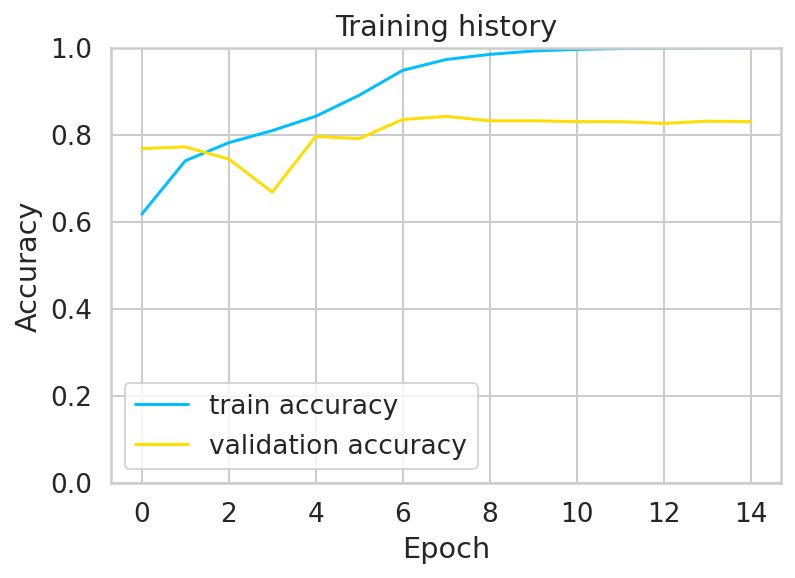

In [27]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

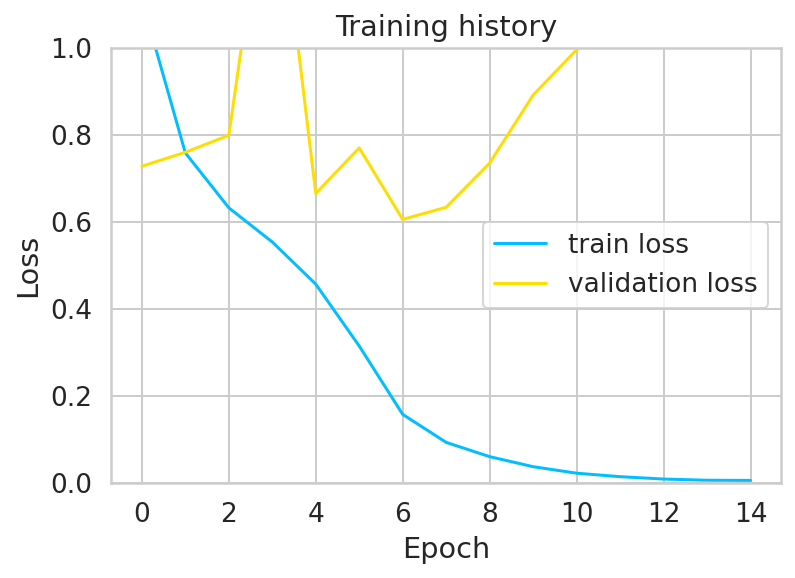

In [28]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [29]:
test_acc, _ = eval_model(base_model,loader_test,criterion)

#test_acc.item()
print('Accuracy on the test set is %.2f %%' %test_acc.item() )

Accuracy on the test set is 0.83 %


In [30]:
y_pred, y_test = get_predictions(
  base_model,
  loader_test
)

In [31]:
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

       plane       0.83      0.86      0.84      1000
         car       0.92      0.90      0.91      1000
        bird       0.81      0.78      0.79      1000
         cat       0.68      0.66      0.67      1000
        deer       0.74      0.86      0.80      1000
         dog       0.75      0.75      0.75      1000
        frog       0.88      0.88      0.88      1000
       horse       0.87      0.80      0.84      1000
        ship       0.89      0.90      0.89      1000
       truck       0.89      0.89      0.89      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



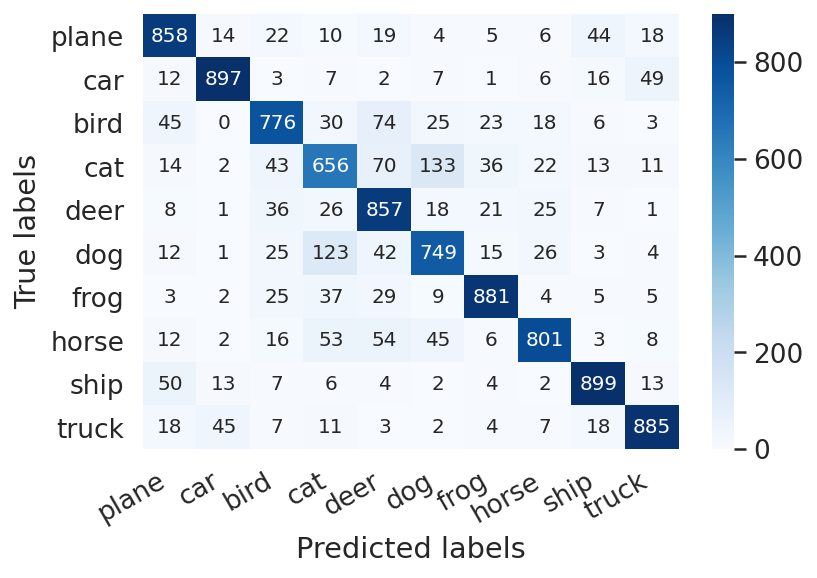

In [32]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
show_confusion_matrix(df_cm)

In [33]:
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(base_model.children())

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 33


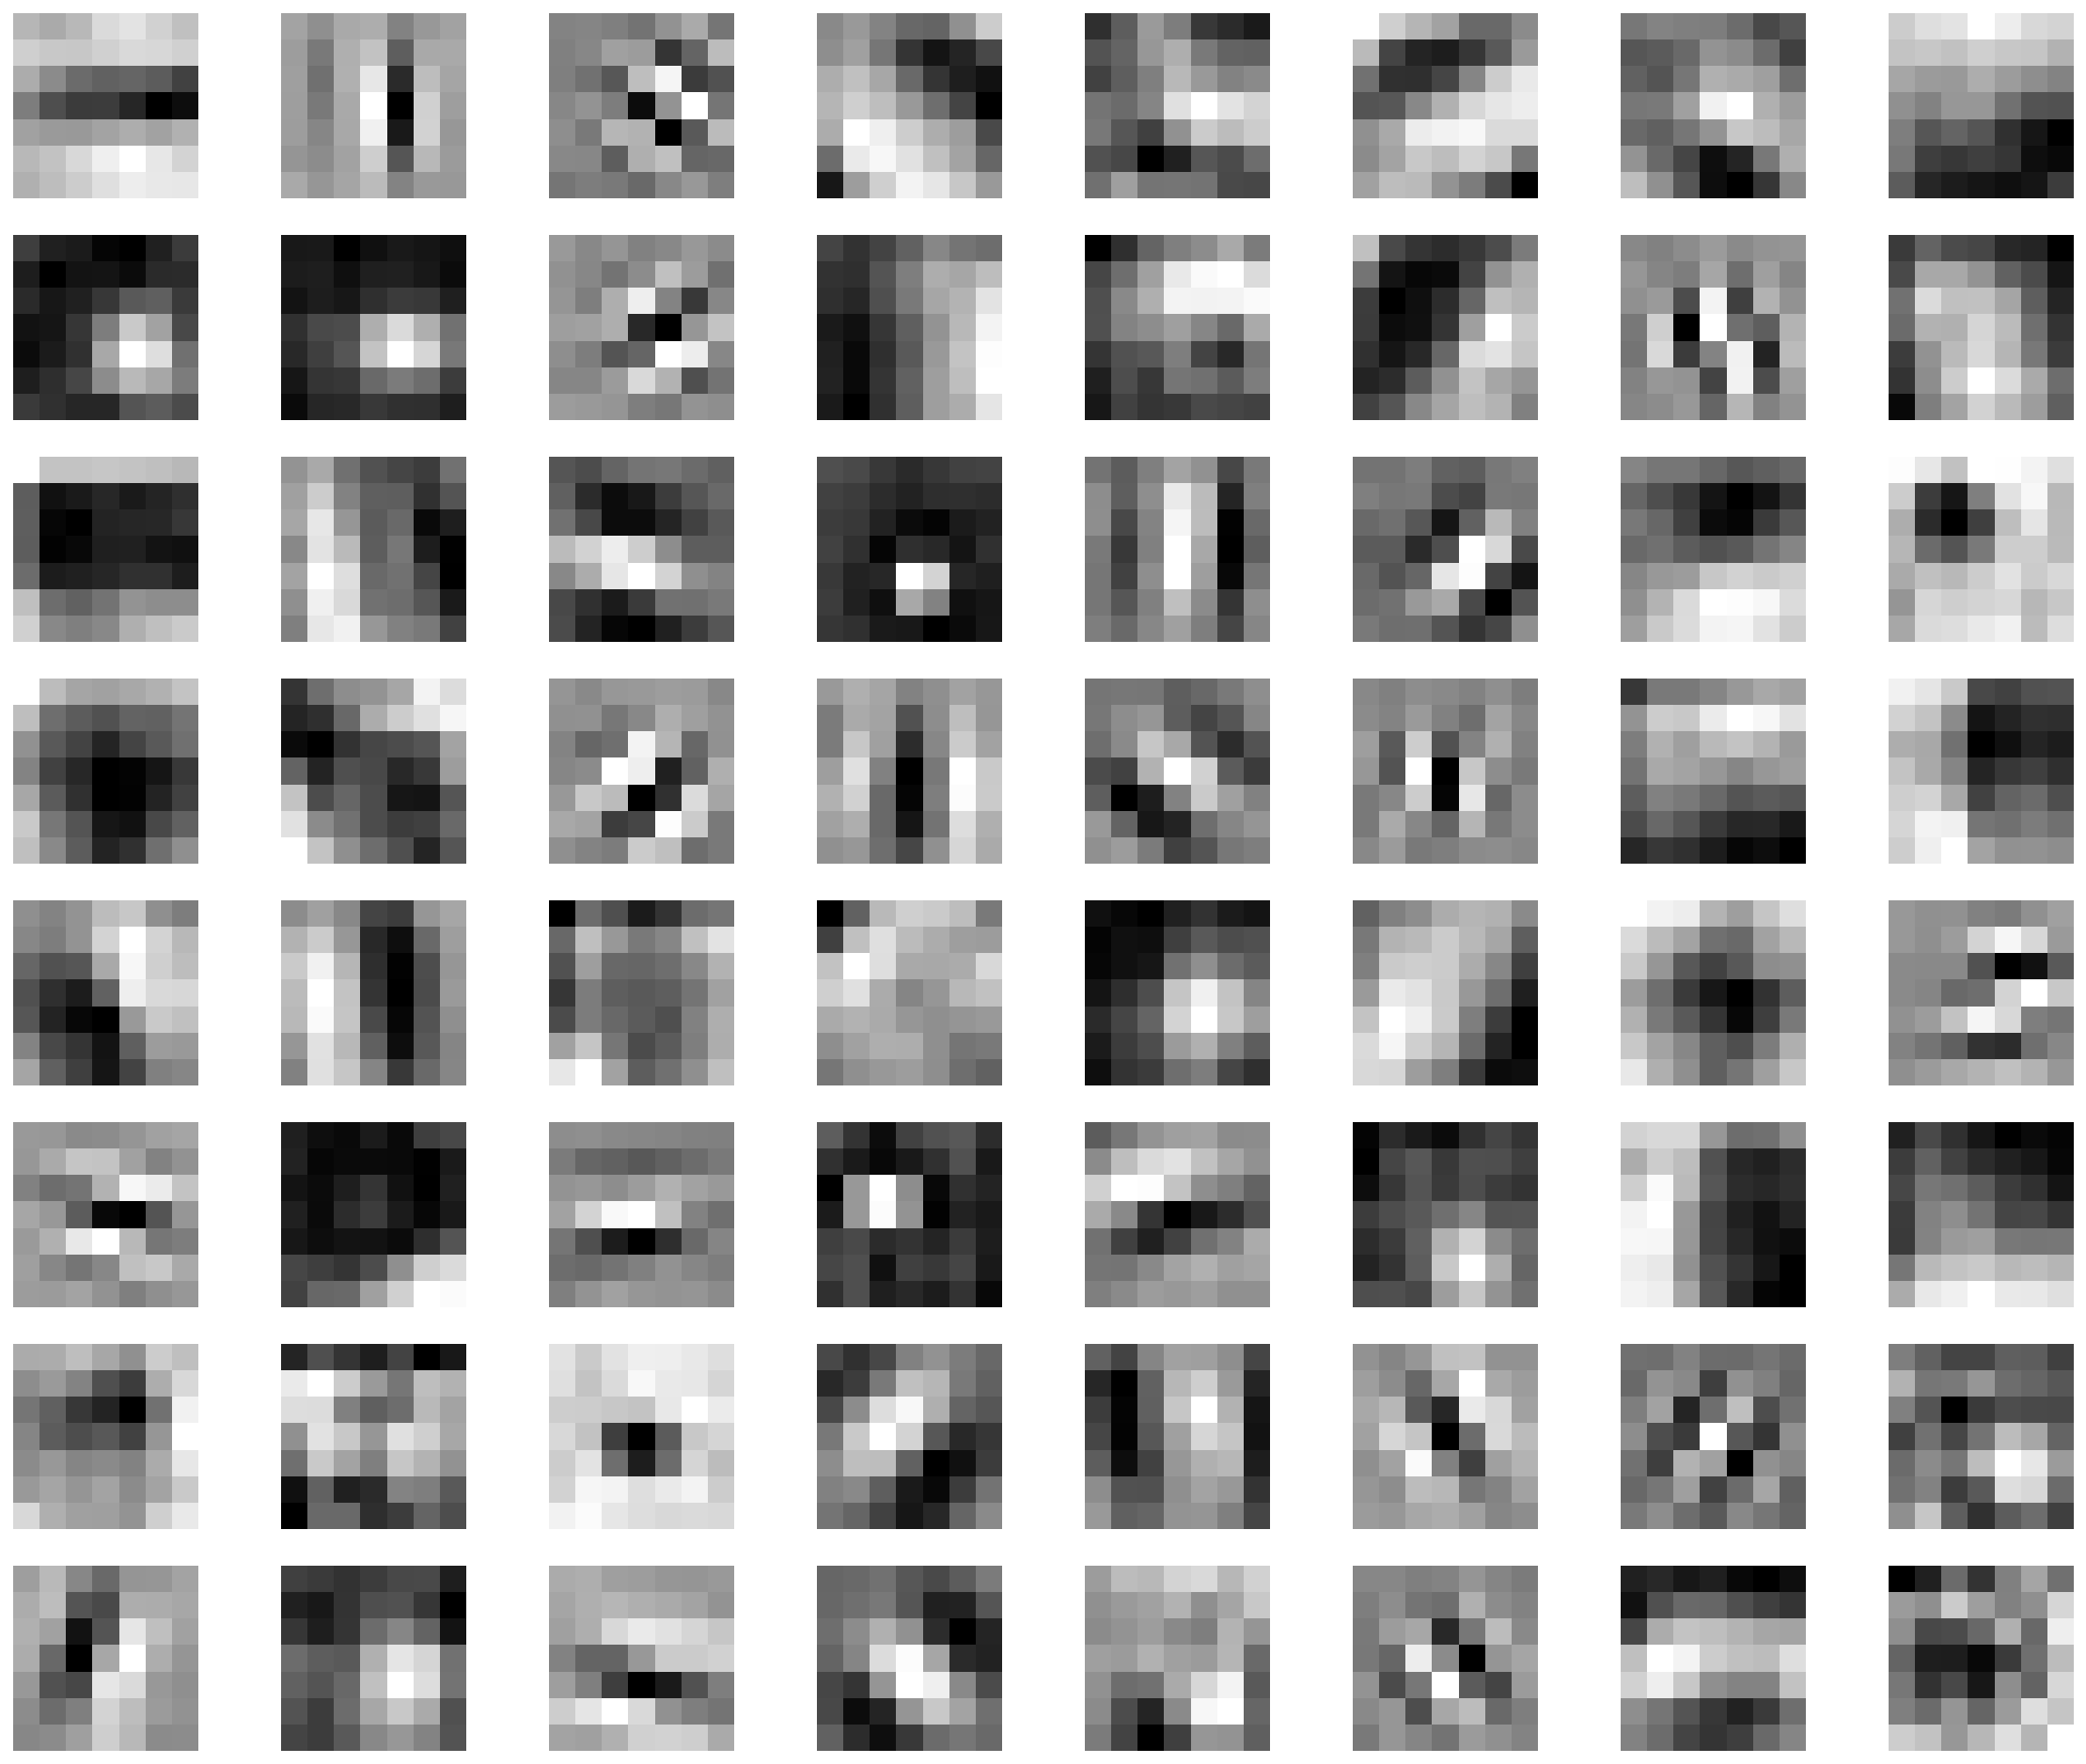

In [34]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    filter = filter.cpu()
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()

torch.Size([64, 250, 375])


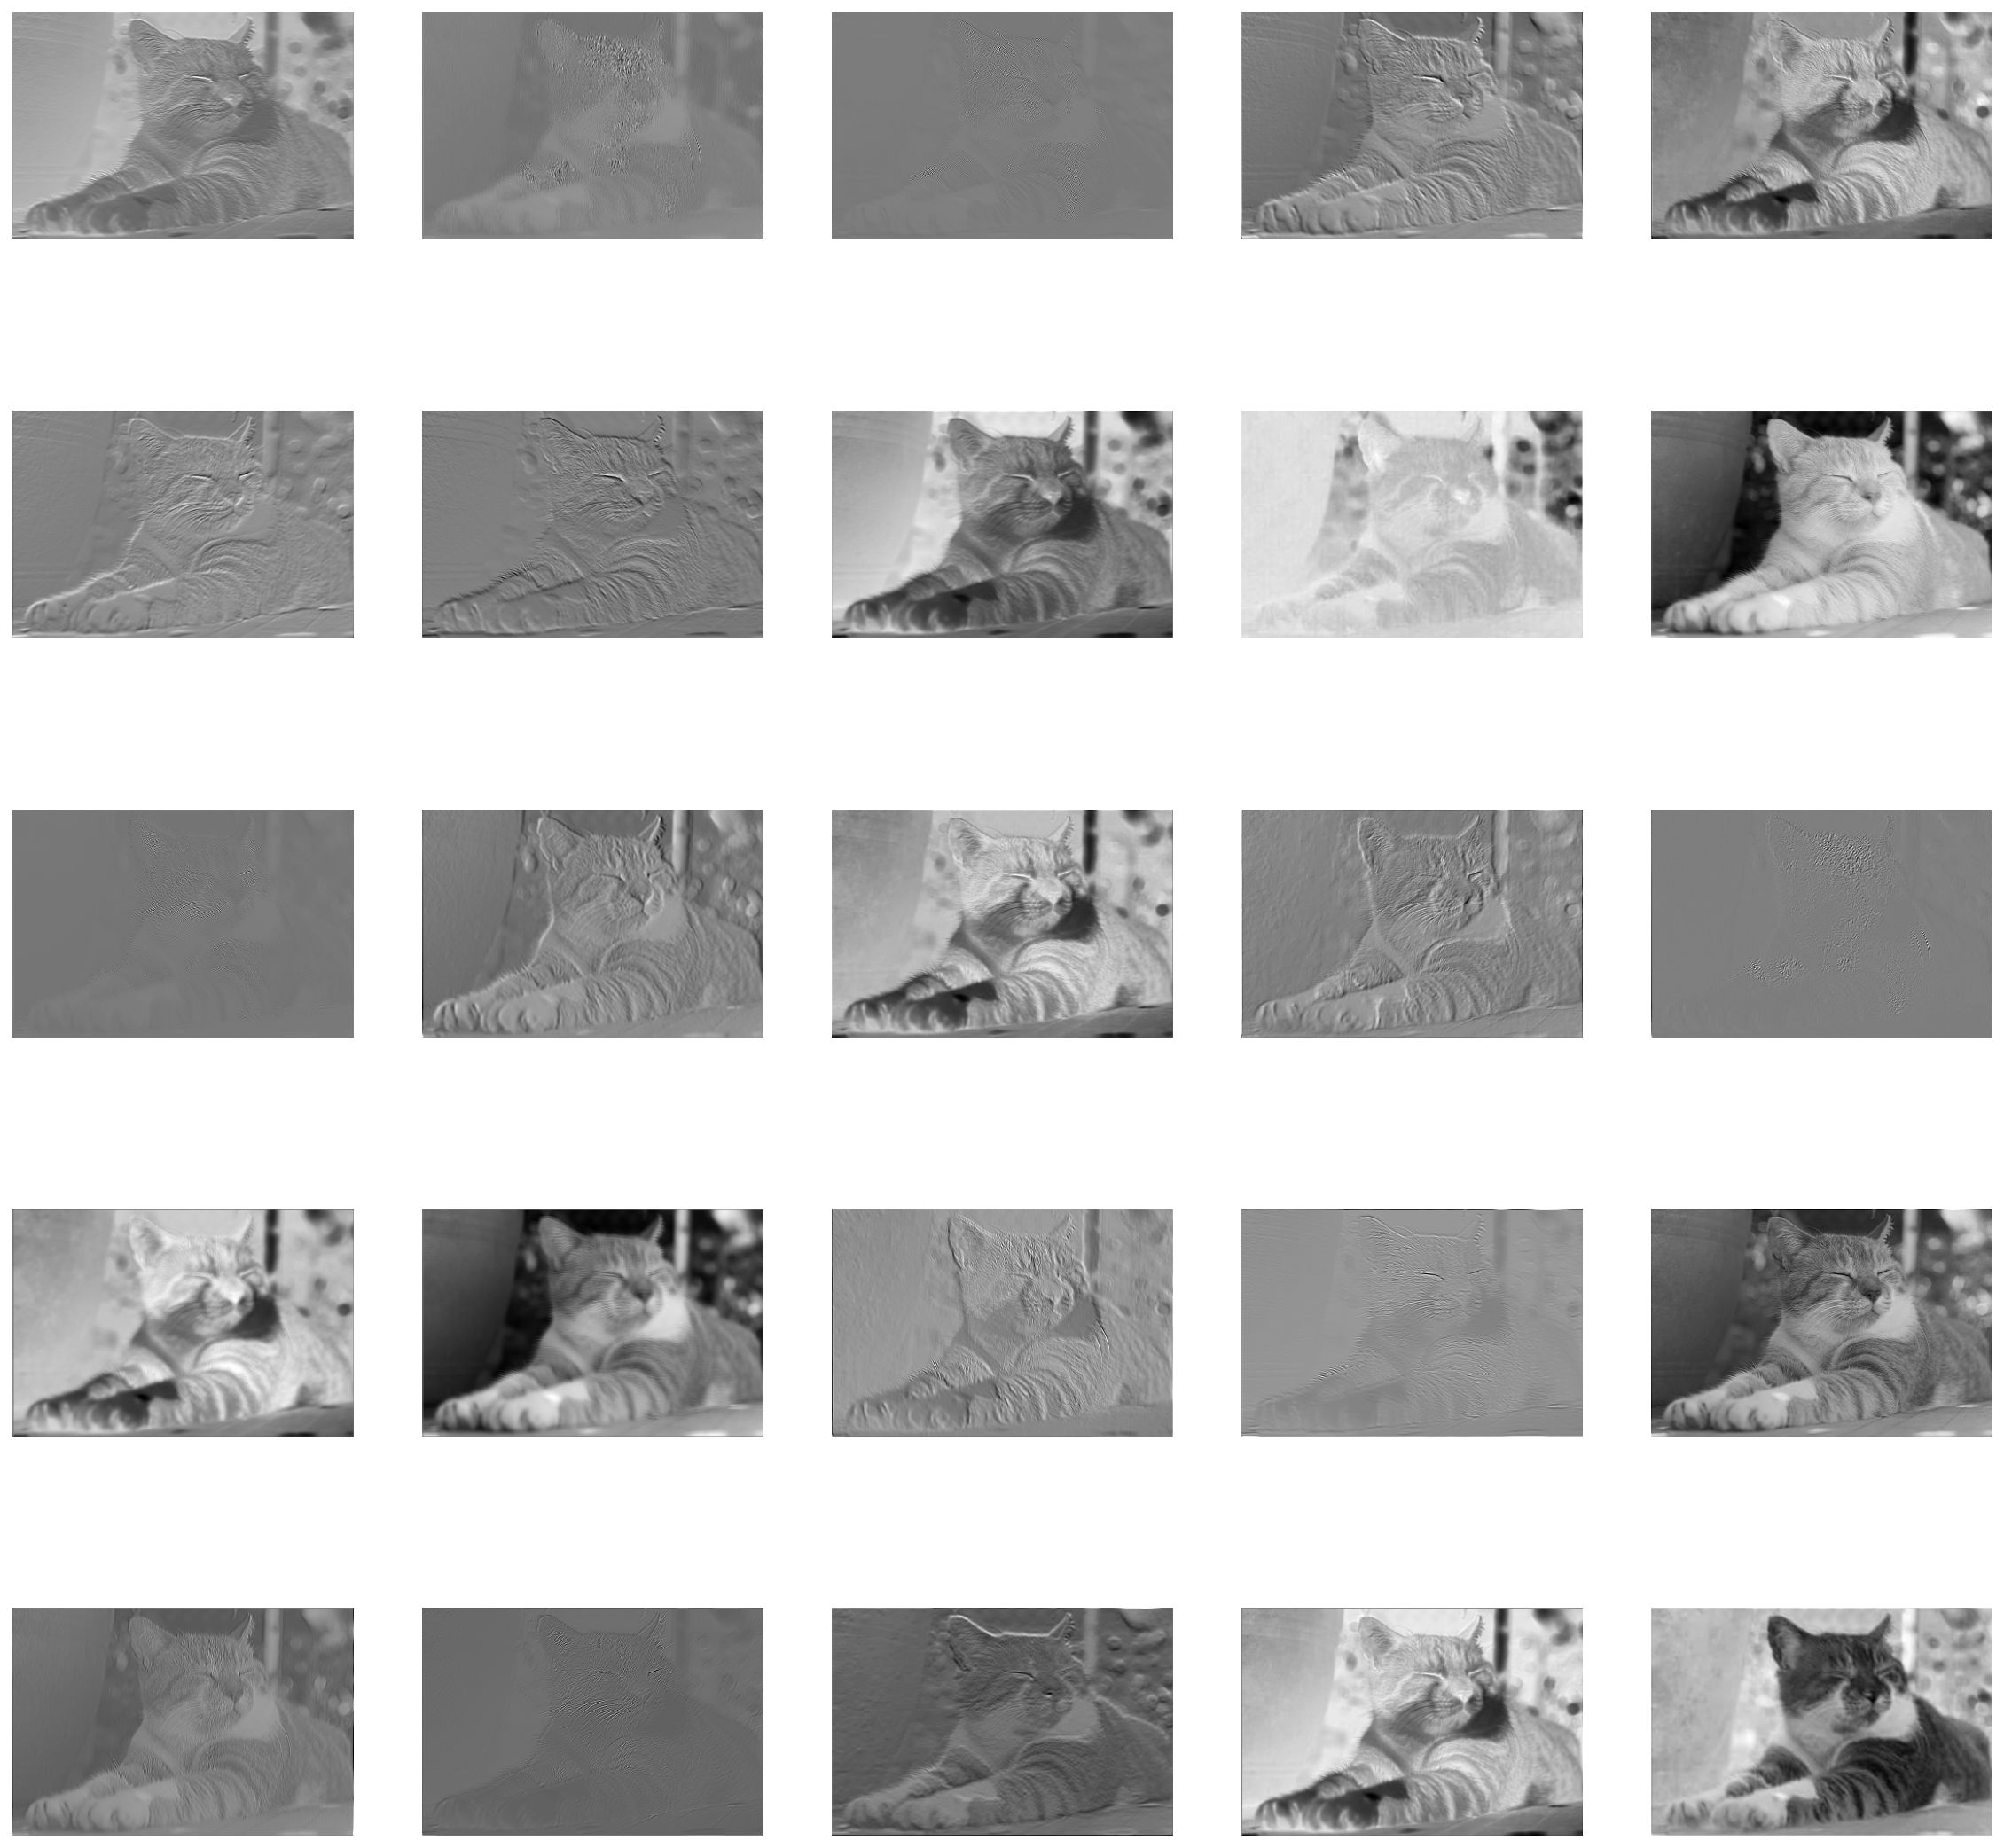

In [35]:
# pass the image through all the layers
img = img.to(device)
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
for num_layer in range(len(outputs)):
    plt.figure(figsize=(20, 20))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 25: # we will visualize only 5x5 blocks from each layer
            break
        plt.subplot(5, 5, i + 1)
        filter = filter.cpu()
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()
    # Showing first layer only for now
    break

#### 2 - Finetune two last layers

In [22]:
frozen_res_mod = models.resnet34(pretrained=True)
for param in frozen_res_mod.parameters():
    param.requires_grad = False

num_ftrs = frozen_res_mod.fc.in_features
frozen_res_mod.fc = nn.Linear(num_ftrs, len(classes))

In [23]:
for name, child in frozen_res_mod.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [24]:
for name, child in frozen_res_mod.named_children():
    if name in ['layer4','fc']:
        print(name + 'has been unfrozen.')
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

layer4has been unfrozen.
fchas been unfrozen.


In [25]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(filter(lambda x: x.requires_grad, frozen_res_mod.parameters()), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [26]:
base_model,history = train_model(frozen_res_mod, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

Epoch 1/15
----------
Iterating through data...
train Loss: 1.3923 Acc: 0.5116
Iterating through data...
val Loss: 1.1353 Acc: 0.6340

Epoch 2/15
----------
Iterating through data...
train Loss: 0.9760 Acc: 0.6588
Iterating through data...
val Loss: 1.2689 Acc: 0.6300

Epoch 3/15
----------
Iterating through data...
train Loss: 0.7073 Acc: 0.7537
Iterating through data...
val Loss: 1.3354 Acc: 0.6230

Epoch 4/15
----------
Iterating through data...
train Loss: 0.5243 Acc: 0.8139
Iterating through data...
val Loss: 1.5053 Acc: 0.5950

Epoch 5/15
----------
Iterating through data...
train Loss: 0.4141 Acc: 0.8532
Iterating through data...
val Loss: 1.6921 Acc: 0.6080

Epoch 6/15
----------
Iterating through data...
train Loss: 0.3195 Acc: 0.8855
Iterating through data...
val Loss: 1.7898 Acc: 0.6200

Epoch 7/15
----------
Iterating through data...
train Loss: 0.1657 Acc: 0.9447
Iterating through data...
val Loss: 1.9196 Acc: 0.6310

Epoch 8/15
----------
Iterating through data...
train L

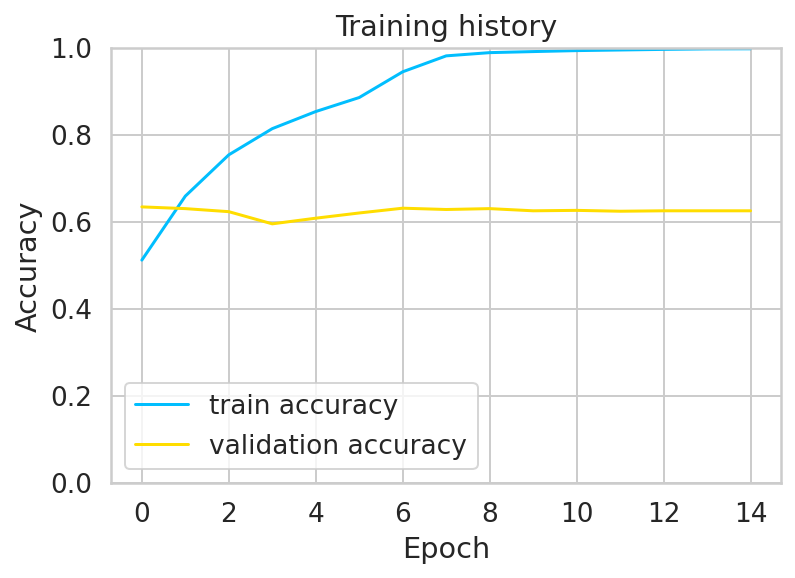

In [27]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

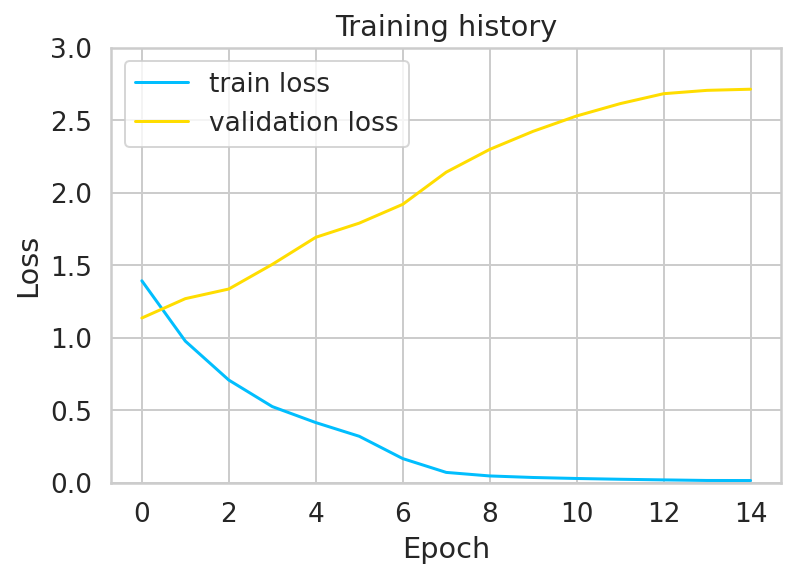

In [28]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 3]);

In [29]:
test_acc, _ = eval_model(base_model,loader_test,criterion)
print('Accuracy on the test set is %.2f %%' %test_acc.item() )

Accuracy on the test set is 0.61 %


In [30]:
y_pred, y_test = get_predictions(
  base_model,
  loader_test
)

In [31]:
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

       plane       0.64      0.60      0.62      1000
         car       0.74      0.68      0.71      1000
        bird       0.53      0.44      0.48      1000
         cat       0.42      0.58      0.49      1000
        deer       0.48      0.64      0.55      1000
         dog       0.61      0.48      0.54      1000
        frog       0.67      0.72      0.70      1000
       horse       0.70      0.66      0.68      1000
        ship       0.76      0.63      0.69      1000
       truck       0.71      0.69      0.70      1000

    accuracy                           0.61     10000
   macro avg       0.63      0.61      0.62     10000
weighted avg       0.63      0.61      0.62     10000



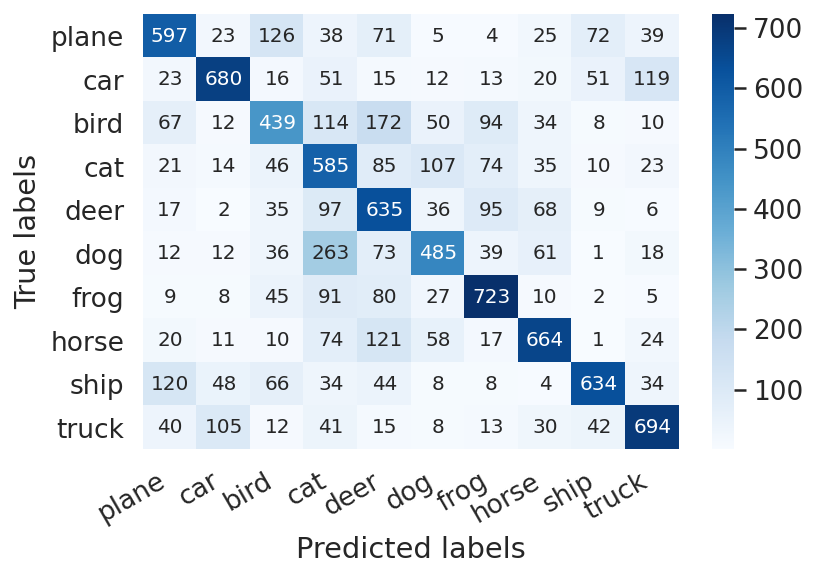

In [32]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
show_confusion_matrix(df_cm)

#### 3 - Finetune only last layer

In [33]:
frozen_res_mod = models.resnet34(pretrained=True)
for param in frozen_res_mod.parameters():
    param.requires_grad = False

num_ftrs = frozen_res_mod.fc.in_features
frozen_res_mod.fc = nn.Linear(num_ftrs, len(classes))

for name, child in frozen_res_mod.named_children():
    if name in ['fc']:
        print(name + 'has been unfrozen.')
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False


criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(filter(lambda x: x.requires_grad, frozen_res_mod.parameters()), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

fchas been unfrozen.


In [34]:
base_model,history = train_model(frozen_res_mod, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

Epoch 1/15
----------
Iterating through data...
train Loss: 1.7814 Acc: 0.3806
Iterating through data...
val Loss: 1.7245 Acc: 0.4250

Epoch 2/15
----------
Iterating through data...
train Loss: 1.6964 Acc: 0.4127
Iterating through data...
val Loss: 1.7264 Acc: 0.4410

Epoch 3/15
----------
Iterating through data...
train Loss: 1.6880 Acc: 0.4170
Iterating through data...
val Loss: 1.7308 Acc: 0.4450

Epoch 4/15
----------
Iterating through data...
train Loss: 1.6860 Acc: 0.4180
Iterating through data...
val Loss: 1.7340 Acc: 0.4450

Epoch 5/15
----------
Iterating through data...
train Loss: 1.6855 Acc: 0.4189
Iterating through data...
val Loss: 1.7362 Acc: 0.4430

Epoch 6/15
----------
Iterating through data...
train Loss: 1.6854 Acc: 0.4195
Iterating through data...
val Loss: 1.7377 Acc: 0.4410

Epoch 7/15
----------
Iterating through data...
train Loss: 1.5531 Acc: 0.4593
Iterating through data...
val Loss: 1.6373 Acc: 0.4430

Epoch 8/15
----------
Iterating through data...
train L

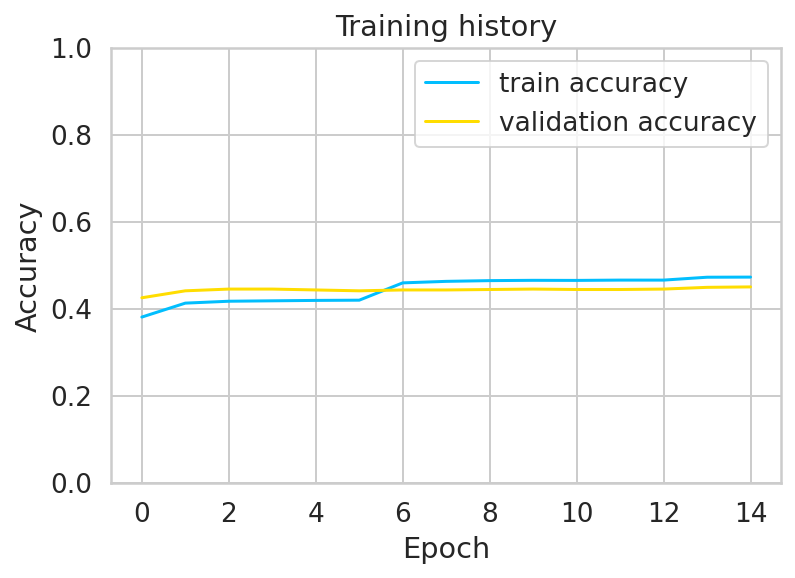

In [35]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

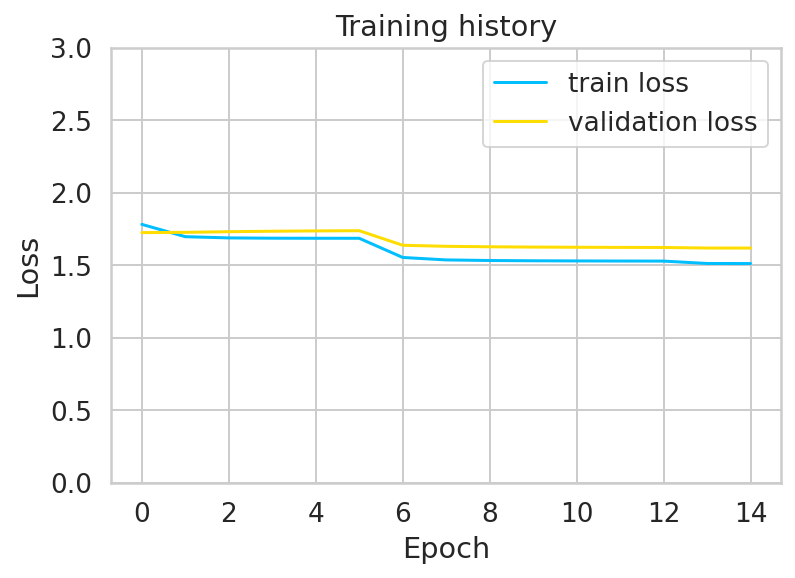

In [36]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 3]);

In [37]:
test_acc, _ = eval_model(base_model,loader_test,criterion)
print('Accuracy on the test set is %.2f %%' %test_acc.item() )

Accuracy on the test set is 0.46 %


In [38]:
y_pred, y_test = get_predictions(
  base_model,
  loader_test
)

In [39]:
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

       plane       0.51      0.48      0.49      1000
         car       0.52      0.51      0.51      1000
        bird       0.38      0.33      0.35      1000
         cat       0.36      0.33      0.34      1000
        deer       0.47      0.38      0.42      1000
         dog       0.42      0.46      0.44      1000
        frog       0.51      0.64      0.57      1000
       horse       0.43      0.56      0.49      1000
        ship       0.56      0.47      0.51      1000
       truck       0.49      0.50      0.50      1000

    accuracy                           0.46     10000
   macro avg       0.46      0.46      0.46     10000
weighted avg       0.46      0.46      0.46     10000



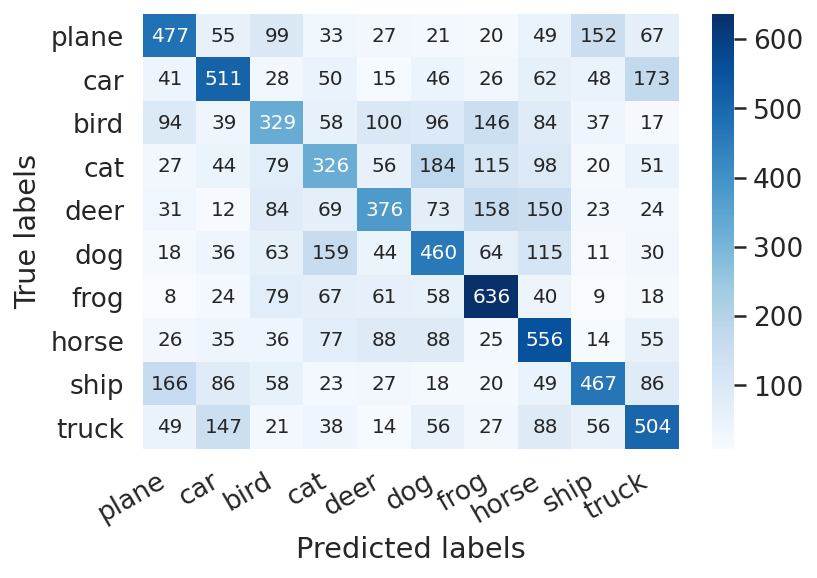

In [40]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
show_confusion_matrix(df_cm)

### III - Existing architecture : Squeezenet

In [41]:
squeeze = torchvision.models.squeezenet1_0(pretrained=False)

In [42]:
print(squeeze)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

#### 1 - Finetuning the classification layer

In [43]:
squeeze = torchvision.models.squeezenet1_0(pretrained=True)

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-a815701f.pth


In [44]:
squeeze.classifier._modules["1"] = nn.Conv2d(512, len(classes), kernel_size=(1, 1))

In [45]:
squeeze.num_classes = len(classes)

In [46]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(squeeze.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [47]:
base_model,history = train_model(squeeze, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

Epoch 1/15
----------
Iterating through data...
train Loss: 2.3074 Acc: 0.1001
Iterating through data...
val Loss: 2.3026 Acc: 0.0870

Epoch 2/15
----------
Iterating through data...
train Loss: 2.3026 Acc: 0.1001
Iterating through data...
val Loss: 2.3026 Acc: 0.0870

Epoch 3/15
----------
Iterating through data...
train Loss: 2.3026 Acc: 0.1006
Iterating through data...
val Loss: 2.3026 Acc: 0.0870

Epoch 4/15
----------
Iterating through data...
train Loss: 2.1325 Acc: 0.1854
Iterating through data...
val Loss: 1.4437 Acc: 0.4810

Epoch 5/15
----------
Iterating through data...
train Loss: 1.1604 Acc: 0.6015
Iterating through data...
val Loss: 1.1268 Acc: 0.6070

Epoch 6/15
----------
Iterating through data...
train Loss: 0.8997 Acc: 0.7009
Iterating through data...
val Loss: 1.0067 Acc: 0.6560

Epoch 7/15
----------
Iterating through data...
train Loss: 0.6712 Acc: 0.7737
Iterating through data...
val Loss: 0.7582 Acc: 0.7440

Epoch 8/15
----------
Iterating through data...
train L

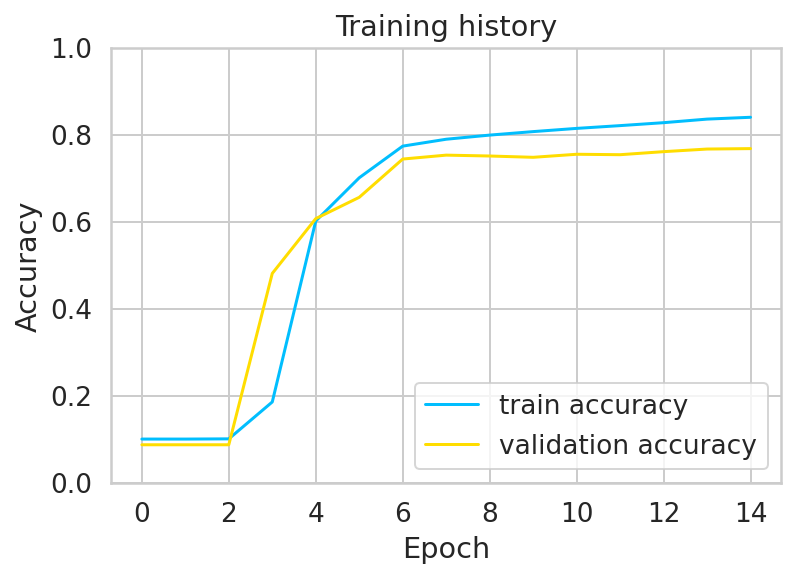

In [48]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

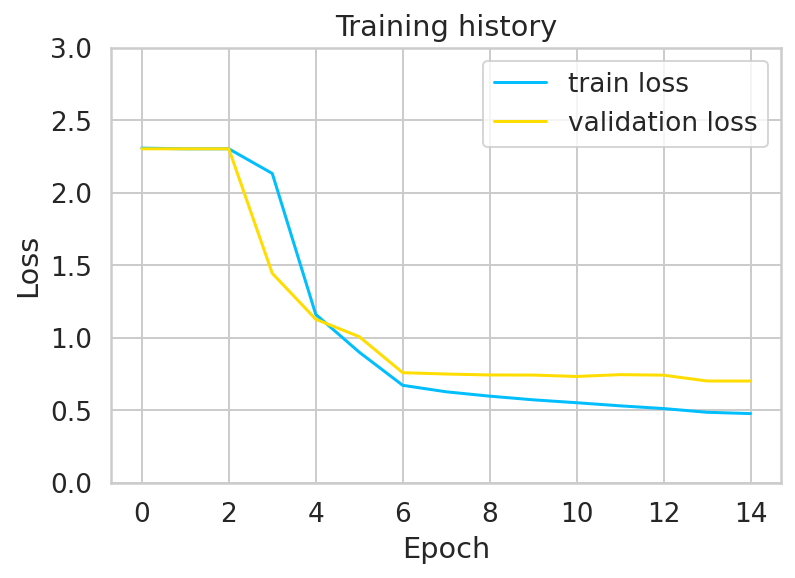

In [49]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 3]);

In [50]:
test_acc, _ = eval_model(base_model,loader_test,criterion)
print('Accuracy on the test set is %.2f %%' %test_acc.item() )

Accuracy on the test set is 0.77 %


In [51]:
y_pred, y_test = get_predictions(
  base_model,
  loader_test
)

In [52]:
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

       plane       0.79      0.81      0.80      1000
         car       0.88      0.83      0.85      1000
        bird       0.72      0.69      0.70      1000
         cat       0.58      0.57      0.58      1000
        deer       0.72      0.76      0.74      1000
         dog       0.70      0.68      0.69      1000
        frog       0.81      0.83      0.82      1000
       horse       0.81      0.80      0.81      1000
        ship       0.88      0.86      0.87      1000
       truck       0.81      0.87      0.84      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



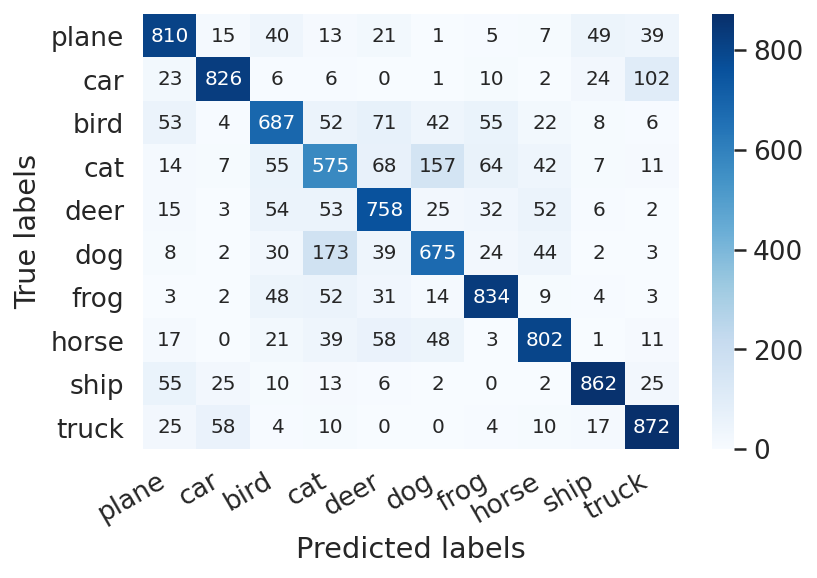

In [53]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
show_confusion_matrix(df_cm)

#### 2 - Training the model from scratch

In [54]:
squeeze = torchvision.models.squeezenet1_0(pretrained=False)

In [55]:
squeeze.classifier._modules["1"] = nn.Conv2d(512, len(classes), kernel_size=(1, 1))

In [56]:
squeeze.num_classes = len(classes)

In [57]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(squeeze.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [58]:
base_model,history = train_model(squeeze, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

Epoch 1/15
----------
Iterating through data...
train Loss: 2.2469 Acc: 0.1359
Iterating through data...
val Loss: 1.9832 Acc: 0.2720

Epoch 2/15
----------
Iterating through data...
train Loss: 1.7649 Acc: 0.3265
Iterating through data...
val Loss: 1.6581 Acc: 0.3770

Epoch 3/15
----------
Iterating through data...
train Loss: 1.5563 Acc: 0.4270
Iterating through data...
val Loss: 1.4624 Acc: 0.4640

Epoch 4/15
----------
Iterating through data...
train Loss: 1.4482 Acc: 0.4690
Iterating through data...
val Loss: 1.4630 Acc: 0.4480

Epoch 5/15
----------
Iterating through data...
train Loss: 1.3668 Acc: 0.5021
Iterating through data...
val Loss: 1.3340 Acc: 0.5240

Epoch 6/15
----------
Iterating through data...
train Loss: 1.2997 Acc: 0.5312
Iterating through data...
val Loss: 1.3470 Acc: 0.5280

Epoch 7/15
----------
Iterating through data...
train Loss: 1.1477 Acc: 0.5859
Iterating through data...
val Loss: 1.1465 Acc: 0.5830

Epoch 8/15
----------
Iterating through data...
train L

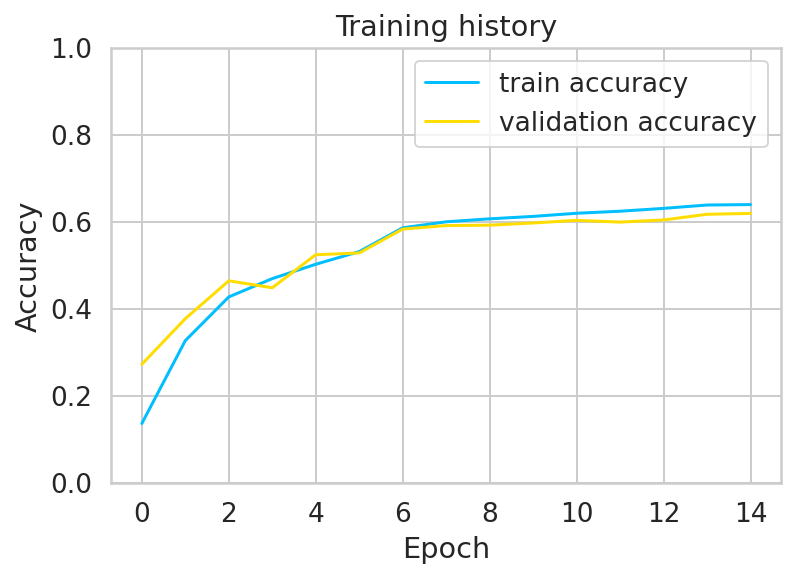

In [59]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

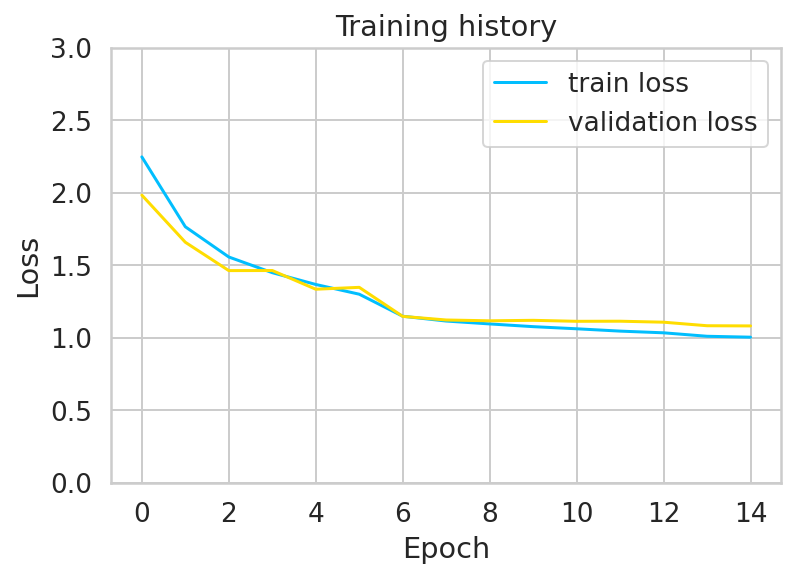

In [60]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 3]);

In [61]:
test_acc, _ = eval_model(base_model,loader_test,criterion)
print('Accuracy on the test set is %.2f %%' %test_acc.item() )

Accuracy on the test set is 0.60 %


In [62]:
y_pred, y_test = get_predictions(
  base_model,
  loader_test
)

In [63]:
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

       plane       0.64      0.64      0.64      1000
         car       0.75      0.73      0.74      1000
        bird       0.42      0.41      0.42      1000
         cat       0.40      0.39      0.40      1000
        deer       0.52      0.44      0.48      1000
         dog       0.51      0.51      0.51      1000
        frog       0.64      0.71      0.67      1000
       horse       0.68      0.67      0.67      1000
        ship       0.69      0.75      0.72      1000
       truck       0.70      0.71      0.71      1000

    accuracy                           0.60     10000
   macro avg       0.59      0.60      0.59     10000
weighted avg       0.59      0.60      0.59     10000



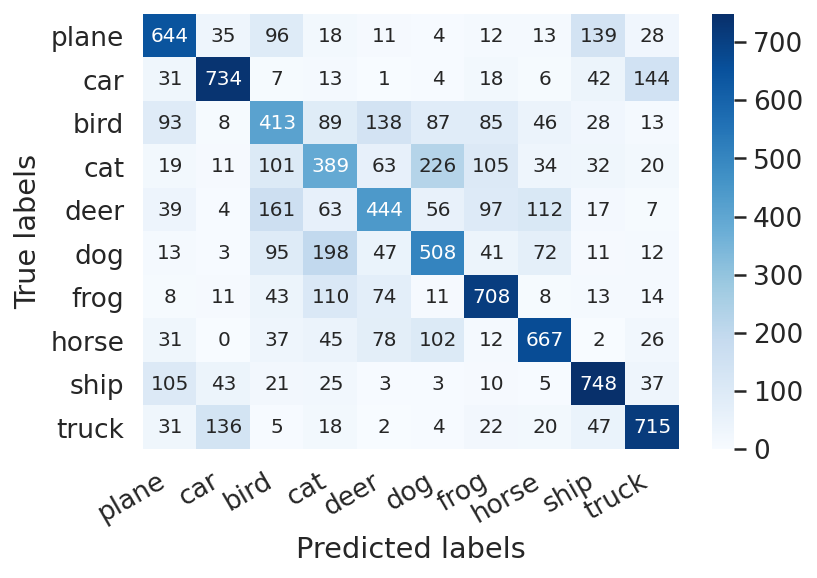

In [64]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
show_confusion_matrix(df_cm)

### IV - CNN Model trained from scratch

In [65]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.fc1 = nn.Linear(in_features=20 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.drop = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(in_features=84, out_features=len(classes))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20 * 5 * 5) #flattening
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [66]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [67]:
base_model,history = train_model(net, criterion, optimizer, exp_lr_scheduler, num_epochs=30)

Epoch 1/30
----------
Iterating through data...
train Loss: 1.6296 Acc: 0.4021
Iterating through data...
val Loss: 1.3555 Acc: 0.5060

Epoch 2/30
----------
Iterating through data...
train Loss: 1.3179 Acc: 0.5307
Iterating through data...
val Loss: 1.2669 Acc: 0.5650

Epoch 3/30
----------
Iterating through data...
train Loss: 1.2140 Acc: 0.5731
Iterating through data...
val Loss: 1.2668 Acc: 0.5880

Epoch 4/30
----------
Iterating through data...
train Loss: 1.1445 Acc: 0.6001
Iterating through data...
val Loss: 1.2775 Acc: 0.5910

Epoch 5/30
----------
Iterating through data...
train Loss: 1.1123 Acc: 0.6144
Iterating through data...
val Loss: 1.3351 Acc: 0.5990

Epoch 6/30
----------
Iterating through data...
train Loss: 1.0819 Acc: 0.6243
Iterating through data...
val Loss: 1.3654 Acc: 0.5760

Epoch 7/30
----------
Iterating through data...
train Loss: 0.8173 Acc: 0.7103
Iterating through data...
val Loss: 1.0856 Acc: 0.6690

Epoch 8/30
----------
Iterating through data...
train L

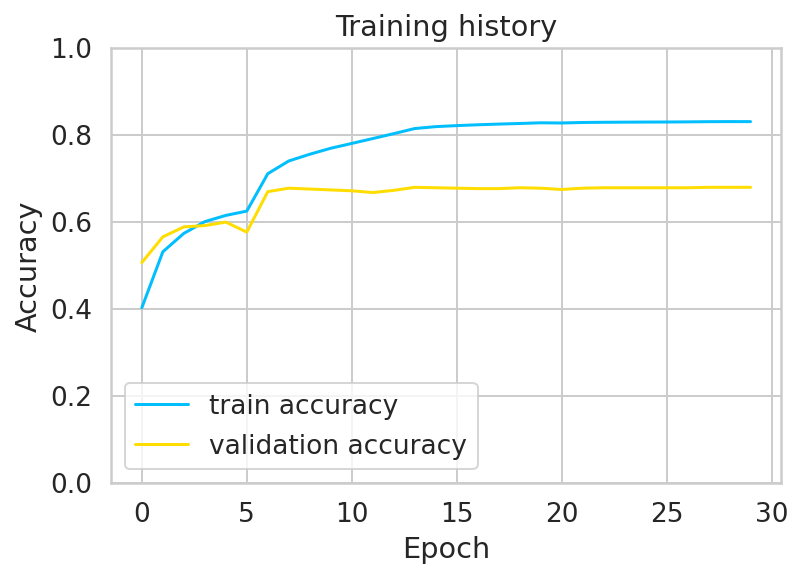

In [68]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

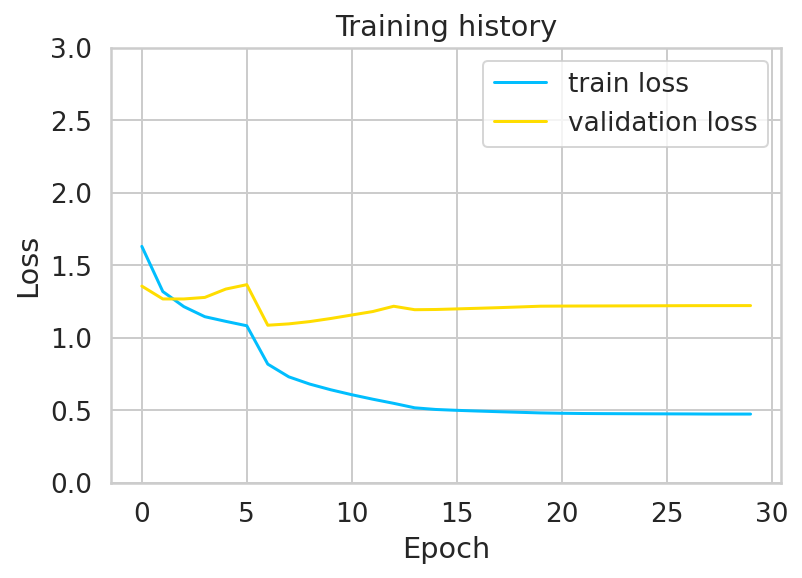

In [69]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 3]);

In [70]:
test_acc, _ = eval_model(base_model,loader_test,criterion)
print('Accuracy on the test set is %.2f %%' %test_acc.item() )

Accuracy on the test set is 0.65 %


In [71]:
y_pred, y_test = get_predictions(
  base_model,
  loader_test
)

In [72]:
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

       plane       0.66      0.69      0.67      1000
         car       0.81      0.77      0.79      1000
        bird       0.55      0.54      0.55      1000
         cat       0.44      0.48      0.46      1000
        deer       0.59      0.58      0.58      1000
         dog       0.54      0.48      0.51      1000
        frog       0.72      0.76      0.74      1000
       horse       0.70      0.70      0.70      1000
        ship       0.77      0.78      0.77      1000
       truck       0.75      0.73      0.74      1000

    accuracy                           0.65     10000
   macro avg       0.65      0.65      0.65     10000
weighted avg       0.65      0.65      0.65     10000



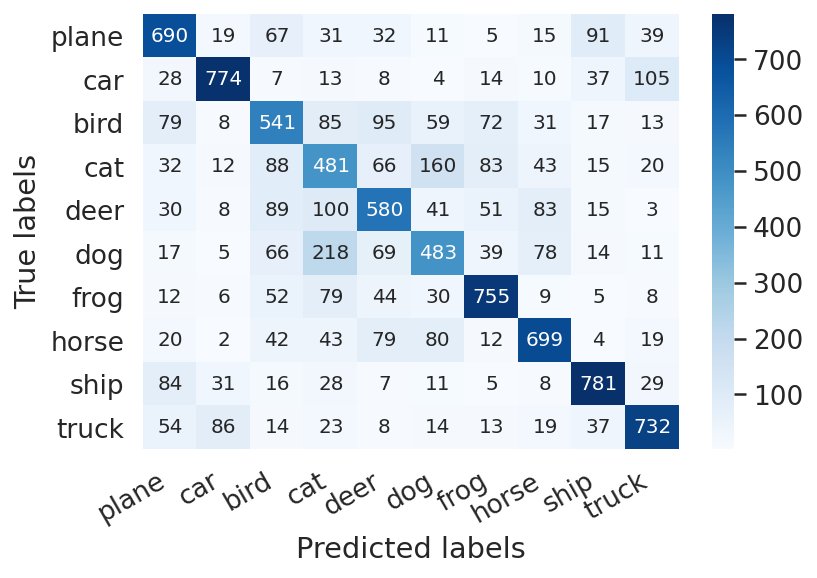

In [73]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
show_confusion_matrix(df_cm)

In [74]:
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(base_model.children())

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 2


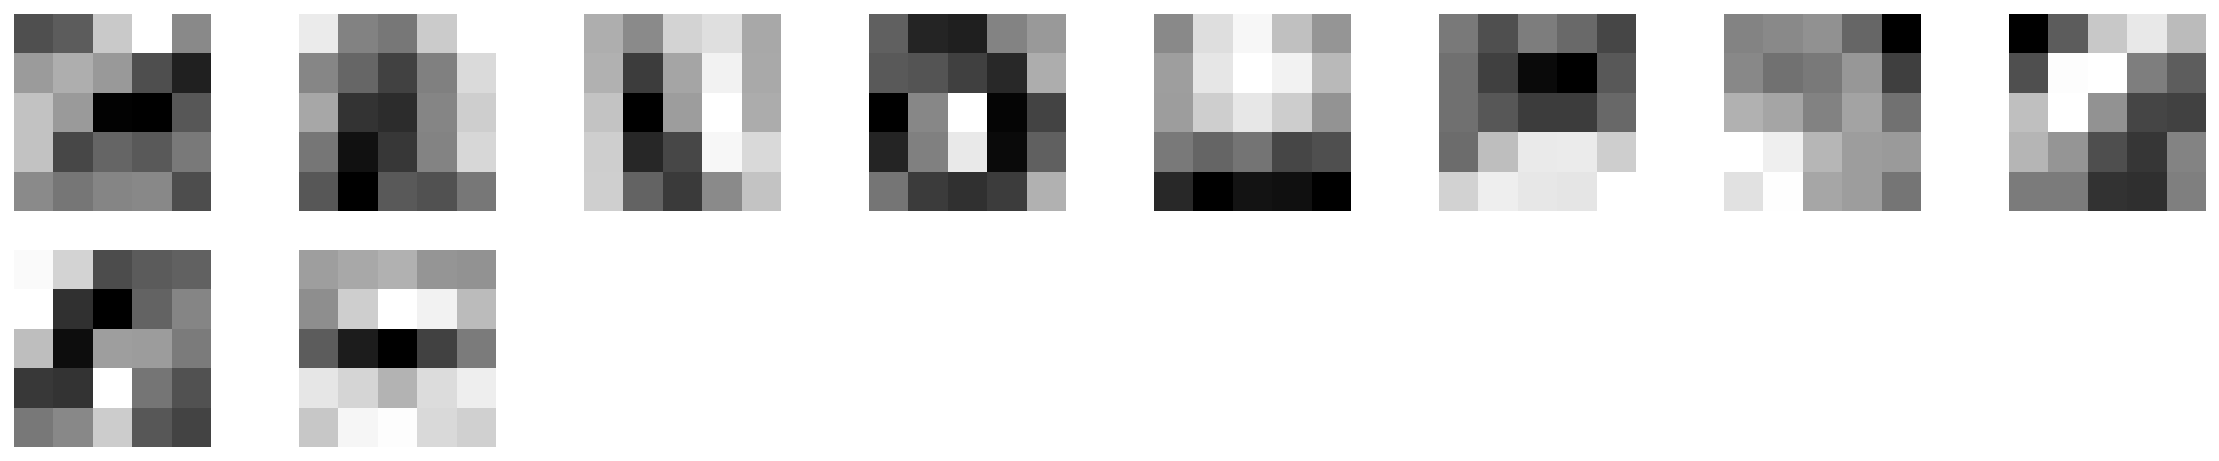

In [75]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    filter = filter.cpu()
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()

torch.Size([10, 496, 746])


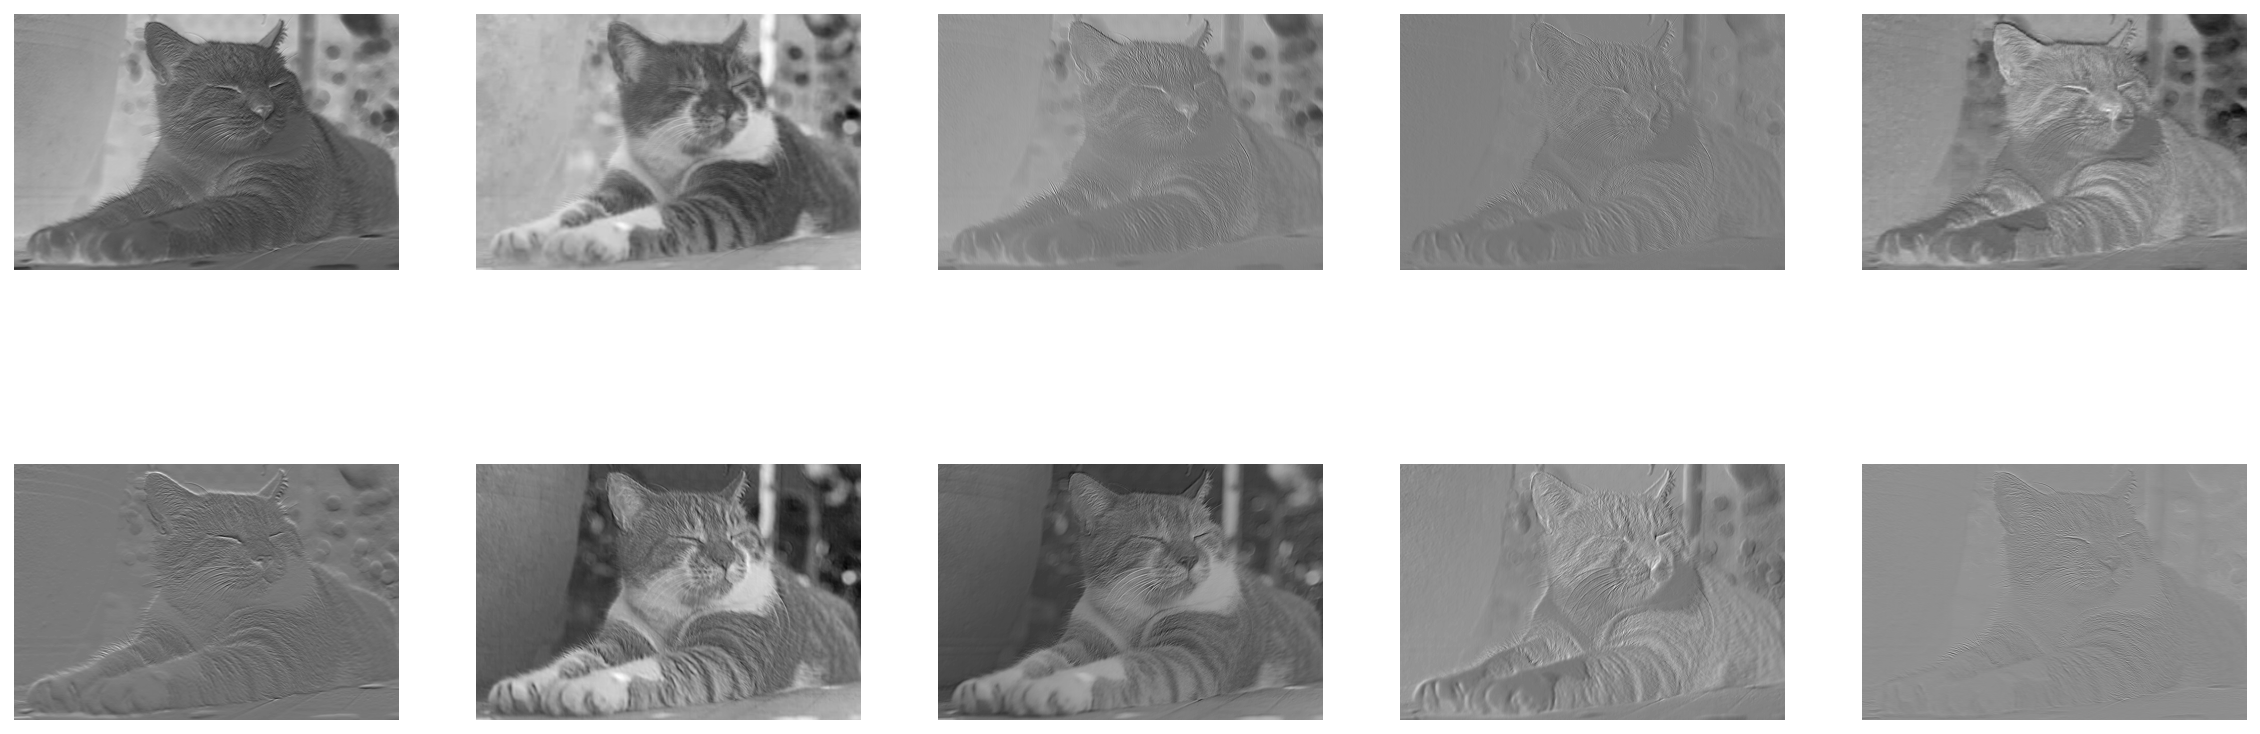

In [76]:
# pass the image through all the layers
img = img.to(device)
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
for num_layer in range(len(outputs)):
    plt.figure(figsize=(20, 20))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 25: # we will visualize only 5x5 blocks from each layer
            break
        plt.subplot(5, 5, i + 1)
        filter = filter.cpu()
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()
    # Showing first layer only for now
    break